# Caso 2: Incorporación de recarga

In [4]:
from geopy.distance import geodesic
import pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory

#----- procesamiento de datos/ encontrando las distancias entre todas las locations -----
# https://geopy.readthedocs.io/en/stable/#module-geopy.distance 

clientes = pd.read_csv('Proyecto_C_Caso2/clients.csv')
depositos = pd.read_csv('Proyecto_C_Caso2/depots.csv')
estaciones = pd.read_csv('Proyecto_C_Caso2/stations.csv')
vehiculos = pd.read_csv('Proyecto_C_Caso2/vehicles.csv')

df = pd.read_csv('Proyecto_C_Caso2/locations_initial.csv')
# tomamos  origen y las 15 localidades dadas en el enunciado
df = df[df['LocationID'] < 16]

df.to_csv('Proyecto_C_Caso2/locations.csv', index=False)

for i in range(len(estaciones)):
    data= {'LocationID': estaciones['LocationID'][i],
            'Longitude': estaciones['Longitude'][i],
            'Latitude': estaciones['Latitude'][i],}
    data_f = pd.DataFrame([data])
    # modo a es de append pa ir añadiendo y como ya tiene encabezados header se pone en False
    data_f.to_csv('Proyecto_C_Caso2/locations.csv', mode='a', header=False, index=False)

locations_csv = pd.read_csv('Proyecto_C_Caso2/locations.csv')

locations = []
for i in range(len(locations_csv)):
    latitud = locations_csv['Latitude'][i]
    longitud = locations_csv['Longitude'][i]
    coord = (latitud, longitud)
    locs_i=[]
    j=0
    while j<27:
        latitud2 = locations_csv['Latitude'][j]
        longitud2 = locations_csv['Longitude'][j]
        coord2 = (latitud2, longitud2)

        locs_i.append(geodesic(coord, coord2).meters)
        j+=1
    locations.append(locs_i)

print (locations)

distancias = []
for i in range(len(locations_csv)):
    latitud = locations_csv['Latitude'][i]
    longitud = locations_csv['Longitude'][i]
    coord = (latitud, longitud)
    locs_i=[]
    j=0
    while j< len(locations_csv):
        latitud2 = locations_csv['Latitude'][j]
        longitud2 = locations_csv['Longitude'][j]
        coord2 = (latitud2, longitud2)

        locs_i.append(geodesic(coord, coord2).kilometers)
    
        j+=1
    # df_locs_i = pd.DataFrame([locs_i])
    # df_locs_i.to_csv('Proyecto_C_Caso2/distancias.csv', mode='a', header=False, index=False)
    distancias.append(locs_i)

print (distancias)


[[0.0, 9717.59469494261, 228557.19274950665, 300247.07645378454, 641492.5513023542, 393218.77004431724, 286464.9613420729, 170668.00043825258, 718614.212324027, 124338.33830178047, 155143.76714018214, 234826.970584616, 691944.6306957034, 88557.02396143429, 171069.55689628245, 691605.5901606007, 643322.2793569304, 718613.1369230595, 287210.3595408545, 16513.82191428154, 228939.59569422406, 300950.4261701461, 338760.0337031762, 441445.4388320872, 211287.5457389888, 149496.7431391009, 157561.6973882787], [9717.59469494261, 0.0, 237376.6226540019, 306593.67487750476, 647074.5318750839, 392305.2511294669, 286319.88781868934, 179878.0521662026, 722310.422968935, 132202.54744597746, 164770.7812172083, 236747.78807155043, 696455.7078086437, 80024.17827028951, 179605.1470567743, 696137.7104168094, 648947.3589372362, 722309.4023501019, 287064.02019560407, 9629.372396346382, 237823.61709166254, 307210.80727674754, 343246.5548667784, 447313.15251536877, 220495.5252345285, 155436.04480908747, 15442

# Formulación matemática del Caso 2: CVRP con Estaciones de Recarga

## 1. Formulación del Modelo

Este modelo extiende el problema clásico de ruteo de vehículos (CVRP) incluyendo decisiones de recarga de combustible en estaciones con distintos precios. Se busca minimizar el costo asociado al recorrido (distancia) y al combustible recargado, asegurando cobertura de demanda y restricciones operacionales.

### 1.1. Conjuntos

- $L = \{1, \dots, n\}$: Conjunto de localidades (puerto, destinos, estaciones).
- $D = \{2, \dots, d\}$: Conjunto de destinos (clientes).
- $V = \{1, \dots, m\}$: Conjunto de vehículos.
- $E = \{d+2, \dots, n\}$: Conjunto de estaciones de recarga.
- $P = \{1\}$: Puerto (depósito inicial y final).

### 1.2. Índices

- $i, j \in L$: Localidades.
- $k \in V$: Vehículos.

### 1.3. Parámetros

- $distancias_{ij}$: Distancia entre $i$ y $j$.
- $D\_demanda_i$: Demanda del cliente $i$.
- $V\_capacidad_k$: Capacidad máxima del vehículo $k$.
- $V\_autonomia_k$: Autonomía del vehículo $k$.
- $E\_costo_i$: Costo de combustible en estación $i$.
- $costo$: Costo por kilómetro (tarifa flete + mantenimiento).

### 1.4. Variables de decisión

- $x_{ijk} \in \{0,1\}$: 1 si el vehículo $k$ viaja de $i$ a $j$.
- $u_{ik} \in \mathbb{Z}$: Orden de visita para eliminación de subtours.
- $c_{ik} \geq 0$: Combustible al llegar a $i$.
- $r_{ik} \geq 0$: Combustible recargado en estación $i$.

---

## 2. Función Objetivo

Minimizar el costo total de transporte y combustible:

$$
\min \sum_{k \in V} \sum_{i \in L} \sum_{j \in L, j \ne i} costo \cdot distancias_{ij} \cdot x_{ijk} + \sum_{k \in V} \sum_{i \in E} E\_costo_i \cdot r_{ik}
$$

---

## 3. Restricciones

### (1) Cada cliente es visitado una única vez:
$$
\sum_{k \in V} \sum_{i \in L, i \ne j} x_{ijk} = 1 \quad \forall j \in D
$$

### (2) Salida desde el puerto:
$$
\sum_{j \in D} x_{1jk} = 1 \quad \forall k \in V
$$

### (3) Retorno al puerto:
$$
\sum_{i \in L, i \ne 1} x_{i1k} = 1 \quad \forall k \in V
$$

### (4) Conservación de flujo:
$$
\sum_{i \in L, i \ne h} x_{ihk} = \sum_{j \in L, j \ne h} x_{hjk} \quad \forall h \in L \setminus \{1\}, \forall k \in V
$$

### (5) Eliminación de subtours (MTZ):
$$
 u_{ik} - u_{jk} + n \cdot x_{ijk} \leq n - 1 \quad \forall i \ne j \in N, \forall k \in V
$$

### (6) Capacidad del vehículo:
$$
\sum_{i \in D} D\_demanda_i \cdot \sum_{j \in L, j \ne i} x_{jik} \leq V\_capacidad_k \quad \forall k \in V
$$

### (7) Dinámica del combustible:
$$
c_{jk} \geq c_{ik} + r_{ik} - distancias_{ij} \cdot x_{ijk} \quad \forall i \ne j \in L, \forall k \in V
$$

### (8) Capacidad del tanque:
$$
c_{ik} \leq V\_autonomia_k \quad \forall i \in L, \forall k \in V
$$
$$
r_{ik} \leq V\_autonomia_k \quad \forall i \in E, \forall k \in V
$$

---

Este modelo garantiza cobertura de clientes, capacidad y autonomía de vehículos, y decisiones óptimas de recarga.


In [5]:
#----- modelo para resolver el 2 -----
# Caso 1:
# Implementar un modelo básico tipo CVRP con un origen nacional (puerto) y destinos (municipios).
# Incluir restricciones de capacidad y autonomía de los vehículos.
# Validar factibilidad de la solución considerando solamente distancia y demanda.

# Caso 2:
# Extender el modelo anterior para incluir decisiones de recarga.
# Tomar en cuenta los diferentes precios de combustible en estaciones a lo largo del recorrido.
# Asegurar que ningún vehículo se quede sin combustible en ninguna parte de la ruta.
# Este caso permite probar estrategias como recarga completa vs. recarga mínima necesaria

Model = ConcreteModel()

numPuertos = len(depositos)
numPuntosDestino = len(clientes)
numLocalidades = len(locations_csv)
numVehiculos = len(vehiculos)
numEstaciones = len(estaciones)

# Conjuntos
P = RangeSet(1, numPuertos)
D = RangeSet(2, numPuntosDestino+1) 
V = RangeSet(1, numVehiculos)
E = RangeSet(numPuntosDestino + 2, numLocalidades)
#  locations con todo
L= RangeSet(1, numLocalidades)

# Parámetros
# Demanda de los clientes
D_demanda = {}
for i in range(2, numPuntosDestino+2):
    D_demanda[i] = clientes['Demand'][i-2]

# Capacidad de los vehículos
V_capacidad = {}
for i in range(1, numVehiculos+1):
    V_capacidad[i] = vehiculos['Capacity'][i-1]

# Autonomía de los vehículos
V_autonomia = {}
for i in range(1, numVehiculos+1):
    V_autonomia[i] = vehiculos['Range'][i-1]

# Costo de recarga en cada estación
E_costo = {}
for i in range(numPuntosDestino + 2, numLocalidades+1):
    E_costo[i] = estaciones['FuelCost'][i-numPuntosDestino-2]

tarifa_flete_km = 5000   # Ft
costo_mantenimiento_km = 700  # Cm
costo = tarifa_flete_km + costo_mantenimiento_km
N_intermedios = RangeSet(2, numLocalidades)  # todo excepto el depósito

# Variables de decisión
Model.x = Var(L,L,V, domain=Binary) # x[i,j,k] = 1 si el vehiculo k viaja de i a j
Model.u = Var(N_intermedios, V, bounds=(1, numLocalidades - 1), domain=Integers)
Model.c = Var(L, V, domain=NonNegativeReals) # combustible
Model.r = Var(E, V, domain=NonNegativeReals) # recarga


# Función objetivo: minimizar la distancia total recorrida y el costo de recarga
Model.obj = Objective(
    expr=sum(costo*distancias[i-1][j-1]*Model.x[i,j,k] 
             for i in L for j in L for k in V if i != j ) +
         sum(E_costo[e]*Model.r[e,k] for e in E for k in V), sense=minimize
)



# Restricción 1: cada cliente debe ser visitado exactamente una vez
Model.res1 = ConstraintList()
for j in D:
    Model.res1.add(
        sum(Model.x[i,j,k] for i in L if i != j for k in V) == 1
    )

# Restricción 2: desde el depósito/puerto sale un nodo por vehículo
Model.res2 = ConstraintList()
for k in V:
    Model.res2.add(
        sum(Model.x[1,j,k] for j in D) == 1
    )

# Restricción 3: al depósito/puerto llega un nodo por vehículo
Model.res3 = ConstraintList()
for k in V:
    Model.res3.add(
        sum(Model.x[i,1,k] for i in L if i != 1) == 1
    )

# Restricción 4: si un vehículo entra a un nodo, también debe salir de él. Conservación de flujo
Model.res4 = ConstraintList()
for k in V:
    for h in L:
        if h != 1:
            Model.res4.add(
                sum(Model.x[i,h,k] for i in L if i != h) == sum(Model.x[h,j,k] for j in L if j != h)
            )

# Restricción 5: eliminación de subciclos (MTZ)
Model.res5 = ConstraintList()
for k in V:
    for i in N_intermedios:
        for j in N_intermedios:
            if i != j:
                Model.res5.add(
                    Model.u[i,k] - Model.u[j,k] + numLocalidades * Model.x[i,j,k] <= numLocalidades - 1
                )

# Restricción 6 : Capacidad de cada vehículo
Model.res6 = ConstraintList()
for k in V:
    Model.res6.add(
        sum(D_demanda[i] * sum(Model.x[j,i,k] for j in L if j != i) for i in D) <= V_capacidad[k]
    )
    
# Restricción 7: Continuidad del nivel de combustible
Model.res7 = ConstraintList()
for k in V:
    for i in L:
        for j in L:
            if i != j:
                recarga = Model.r[i, k] if i in E else 0  # solo recarga si está en estación
                Model.res7.add(
                    Model.c[j, k] >= Model.c[i, k] + recarga - distancias[i-1][j-1] * Model.x[i, j, k]
                )

# Restricción 8: el nivel de combustible y la recarga no pueden exceder la capacidad del tanque
Model.res8 = ConstraintList()
for k in V:
    for i in L:
        Model.res8.add(
            Model.c[i, k] <= V_autonomia[k]
        )
    for i in E:
        Model.res8.add(
            Model.r[i, k] <= V_autonomia[k]
        )

solver = SolverFactory('glpk')
solver.options['tmlim'] = 300 # tiempo límite de 5 minutos
results = solver.solve(Model, tee=True)


def exportar_resultados_vehiculos(Model, distancias, D_demanda, V_capacidad, V_autonomia, E_costo, L, D, E, V, velocidad=50, tarifa_flete=5000, costo_mantenimiento=700):
    columnas = [
        'VehicleId', 'LoadCap', 'FuelCap', 'RouteSequence', 'Municipalities', 'DemandSatisfied',
        'InitLoad', 'InitFuel', 'RefuelStops', 'RefuelAmounts', 'Distance', 'Time', 'FuelCost',
        'TotalCost'
    ]
    resultados = []
    # recrear el modelo para obtener los resultados
    for k in V:
        ruta = [1]
        actual = 1

        while True:
            siguiente = None
            for j in L:
                if j != actual and Model.x[actual, j, k].value and Model.x[actual, j, k].value > 0.5:
                    siguiente = j
                    ruta.append(j)
                    actual = j
                    break
            if siguiente is None or actual == 1:
                break
            

        ruta_nombres = ["PTO"] + [
            f"MUN{str(nodo).zfill(2)}" if nodo not in E else f"EST{str(nodo).zfill(2)}" 
            for nodo in ruta[1:-1]
        ] + ["PTO"]
        municipios = [n for n in ruta if n in D_demanda]
        demandas = [D_demanda[n] for n in municipios]
        total_demanda = sum(demandas)
        distancia_total = sum(distancias[ruta[i]-1][ruta[i+1]-1] for i in range(len(ruta)-1))
        tiempo = round(distancia_total / velocidad, 2)
        refuel_stops = [i for i in ruta if i in E and Model.r[i, k].value > 0.1] # es para decir que el vehiculo recarga en la estacion i, como si fuera recarga[i,k] > 0 
        refuel_amounts = [round(Model.r[i, k].value, 2) for i in refuel_stops]
        fuel_cost = sum(Model.r[i, k].value * E_costo[i] for i in E if Model.r[i, k].value > 0.1)
        fuel_cost = round(fuel_cost, 2)
        refuel_amounts = [round(Model.r[i, k].value, 2) for i in refuel_stops]
        costo_km = tarifa_flete + costo_mantenimiento
        total_cost = round(distancia_total * costo_km + fuel_cost)

        resultados.append([
            f"CAM{str(k).zfill(3)}",                                                # VehicleId
            V_capacidad[k],                                                         # LoadCap
            V_autonomia[k],                                                         # FuelCap
            ' - '.join(ruta_nombres),                                               # RouteSequence
            len(municipios),                                                        # Municipalities
            ' - '.join(str(int(d)) if d.is_integer() else str(d) for d in demandas),# DemandSatisfied 
            total_demanda,                                                          # InitialLoad
            V_autonomia[k],                                                         # InitFuel
            len(refuel_stops),                                                      # RefuelStops
            ' - '.join(str(a) for a in refuel_amounts) if refuel_amounts else "0",  # RefuelAmounts
            round(distancia_total, 1),                                              # Distance
            tiempo,                                                                 # Time
            fuel_cost,                                                              # FuelCost
            total_cost                                                              # TotalCost
        ])


    df_resultados = pd.DataFrame(resultados, columns=columnas)
    df_resultados.to_csv("Proyecto_C_Caso2/verificacion_caso2.csv", index=False)
    return df_resultados

df = exportar_resultados_vehiculos(Model, distancias, D_demanda, V_capacidad, V_autonomia, E_costo, L, D, E, V)
distancia_total = df['Distance'].sum()
print(f'Distancia total recorrida por todos los vehículos: {round(distancia_total, 2)} km')

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 300 --write C:\Users\GABRIE~1\AppData\Local\Temp\tmp22e7tptl.glpk.raw
 --wglp C:\Users\GABRIE~1\AppData\Local\Temp\tmptbnimnl0.glpk.glp --cpxlp
 C:\Users\GABRIE~1\AppData\Local\Temp\tmpn4fivtu5.pyomo.lp
Reading problem data from 'C:\Users\GABRIE~1\AppData\Local\Temp\tmpn4fivtu5.pyomo.lp'...
C:\Users\GABRIE~1\AppData\Local\Temp\tmpn4fivtu5.pyomo.lp:61526: warning: lower bound of variable 'x6' redefined
C:\Users\GABRIE~1\AppData\Local\Temp\tmpn4fivtu5.pyomo.lp:61526: warning: upper bound of variable 'x6' redefined
7115 rows, 3836 columns, 32636 non-zeros
3640 integer variables, 3510 of which are binary
65036 lines were read
Writing problem data to 'C:\Users\GABRIE~1\AppData\Local\Temp\tmptbnimnl0.glpk.glp'...
54471 lines were written
GLPK Integer Optimizer 5.0
7115 rows, 3836 columns, 32636 non-zeros
3640 integer variables, 3510 of which are binary
Preprocessing...
3260 constraint coefficient(s) were redu

In [6]:
pip install folium


Note: you may need to restart the kernel to use updated packages.


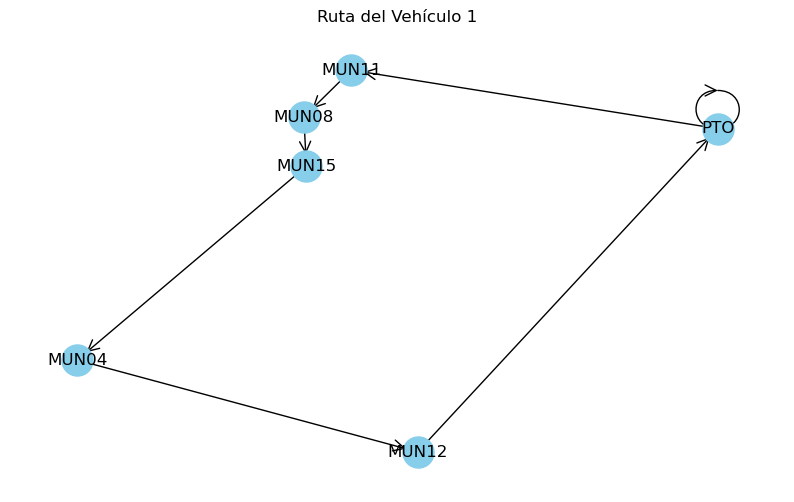

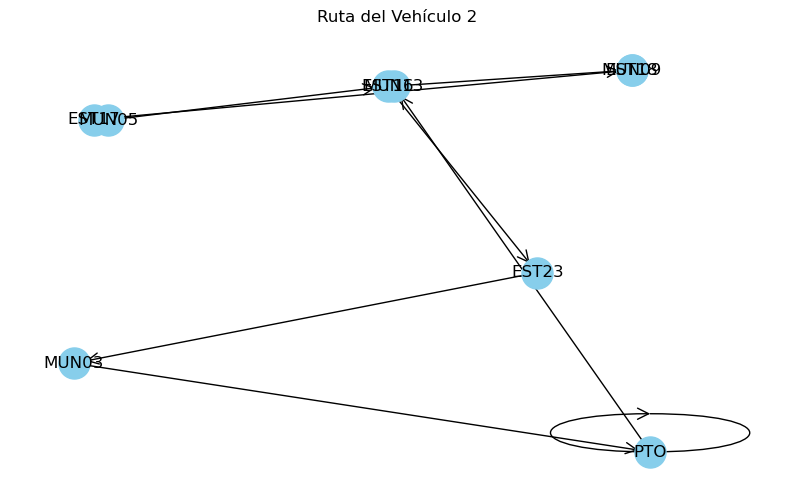

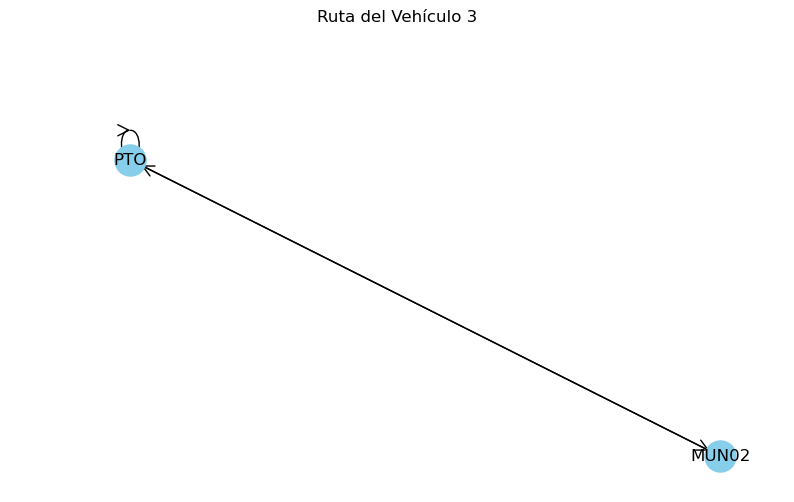

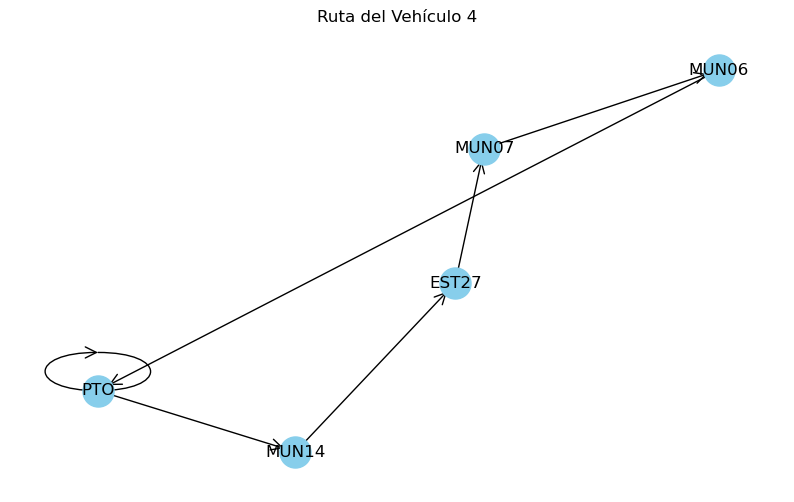

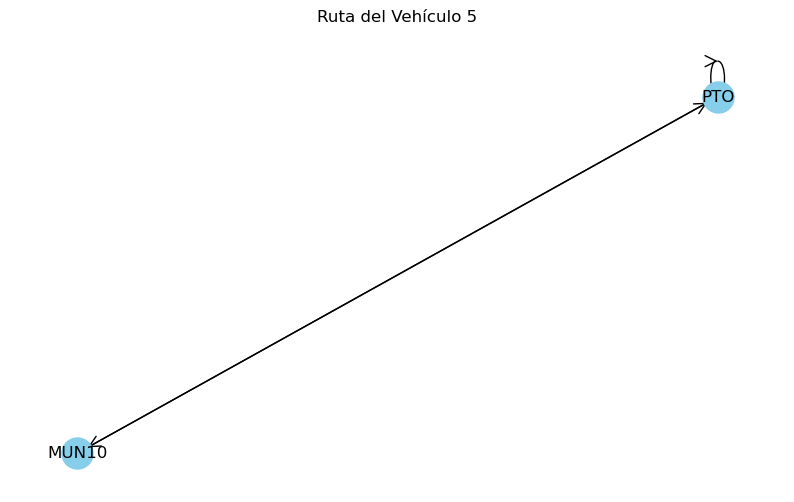

In [15]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx


# Cargar datos
df = pd.read_csv("Proyecto_C_Caso2/verificacion_caso2.csv")
locs = pd.read_csv("Proyecto_C_Caso2/locations.csv")

m = folium.Map(location=[locs["Latitude"].mean(), locs["Longitude"].mean()], zoom_start=6)

# Puntos: municipios (azul) y estaciones (verde)
for _, row in locs.iterrows():
    color = "blue" if row["LocationID"] < 16 else "green"
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=6,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f'ID: {row["LocationID"]}'
    ).add_to(m)

# colores a cada vehículo
vehicle_ids = df["VehicleId"].unique()
colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
vehicle_colors = {vid: colors[i % len(colors)] for i, vid in enumerate(vehicle_ids)}

for _, fila in df.iterrows():
    vehicle_id = fila["VehicleId"]
    color = vehicle_colors.get(vehicle_id, "black")

    secuencia = fila["RouteSequence"].split(" - ")
    ids = []
    for elem in secuencia:
        if elem == "PTO":
            ids.append(1)
        elif "MUN" in elem or "EST" in elem:
            ids.append(int(elem[3:]))

    coords = [[locs.loc[locs["LocationID"] == i, "Latitude"].values[0],
               locs.loc[locs["LocationID"] == i, "Longitude"].values[0]] for i in ids]

    folium.PolyLine(
        coords,
        color=color,
        weight=3.0,
        opacity=0.9,
        popup=folium.Popup(f"Vehículo: {vehicle_id}", parse_html=True)
    ).add_to(m)


# Coordenadas de cada nodo
coords = {i+1: (locations_csv['Longitude'][i], locations_csv['Latitude'][i]) for i in range(len(locations_csv))}

for k in V:
    G = nx.DiGraph()
    ruta = [1]
    actual = 1
    while True:
        next_nodo = None
        for j in L:
            if j != actual and Model.x[actual, j, k].value == 1 and not (actual == 1 and j == 1):
                next_nodo = j
                ruta.append(j)
                actual = j
                break
        if next_nodo == 1 or next_nodo is None:
            break
    if len(ruta) > 1:
        G.add_nodes_from(ruta)
        for i in range(len(ruta)-1):
            G.add_edge(ruta[i], ruta[i+1])

        etiquetas = {}
        for n in ruta:
            if n == 1:
                etiquetas[n] = "PTO"
            elif n >= 16:
                etiquetas[n] = f"EST{n:02d}"
            else:
                etiquetas[n] = f"MUN{n:02d}"
    if len(ruta) > 1:
        ruta.append(1)  # cerrar ciclo

        G.add_nodes_from(ruta)
        for i in range(len(ruta)-1):
            G.add_edge(ruta[i], ruta[i+1])

        plt.figure(figsize=(10,6))
        pos = {n: coords[n] for n in ruta}
        nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
        nx.draw_networkx_labels(G, pos, labels={n:etiquetas[n] for n in ruta})
        nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
        plt.title(f"Ruta del Vehículo {k}")
        plt.axis('off')
        plt.show()

#m.save("Proyecto_C_Caso2/mapa_rutas_caso2.html")

m

## Visualización

Se generó un mapa interactivo con folium que muestra:

- Municipios (clientes) en azul.

- Estaciones de recarga en verde.

- Rutas nacionales planificadas en un color diferente por cada vehículo. Azul para el vehículo 1, amarillo para el vehículo 2, verde para el vehículo 3, rojo para el vehículo 4, y morado para el vehículo 5.

Este mapa permite verificar visualmente que todas las rutas parten y regresan al puerto (PTO), y que algunas rutas requieren estaciones de recarga intermedias.

## Analisis Caso 2

El modelo del Caso 2 fue formulado como un problema de optimización entero mixto, utilizando la herramienta Pyomo y resuelto mediante el solver GLPK. Se incluyeron múltiples restricciones, entre ellas la cobertura de demanda, la capacidad máxima de los vehículos, su autonomía, y decisiones de recarga en estaciones con precios variables. Para evitar la formación de subtours se implementó la formulación tipo MTZ (Miller–Tucker–Zemlin), que garantiza rutas válidas sin ciclos parciales.

Las rutas generadas permiten una cobertura nacional efectiva. Se logra atender regiones clave del país, desde la costa norte (Cartagena, Santa Marta) hasta el suroccidente (Cali, Armenia), evidenciando que el modelo puede planificar de forma eficiente rutas largas que requieren recarga intermedia. Justamente, algunas estaciones como EST01, EST02 y EST03 aparecen de forma recurrente en las soluciones, lo cual demuestra su valor estratégico en la red de rutas.

La eficiencia en el uso de la capacidad de los vehículos también es evidente. Se observa que cada camión transporta una carga proporcional a su capacidad máxima, sin presentar trayectos vacíos o subutilizados. Esta eficiencia se complementa con una estrategia de recarga que prioriza estaciones más baratas y cercanas, permitiendo reducir los costos sin sacrificar cobertura.

En términos de costos, el combustible representa una fracción significativa del costo total. En rutas extensas, se observa la necesidad de realizar múltiples recargas. Si bien en este caso no se incluyeron peajes, el análisis deja ver que el impacto del combustible ya permite diferenciar entre rutas más o menos costosas. Además, los tiempos de recorrido calculados con una velocidad promedio de 50 km/h ofrecen una base útil para estimar duración operativa y logística en escenarios reales.

El uso del puerto como punto de salida y retorno de cada ruta genera eficiencia y simplicidad en la planificación. Sin embargo, sería interesante evaluar escenarios alternativos descentralizados para estudiar si existen beneficios adicionales en términos de distancia o tiempo.

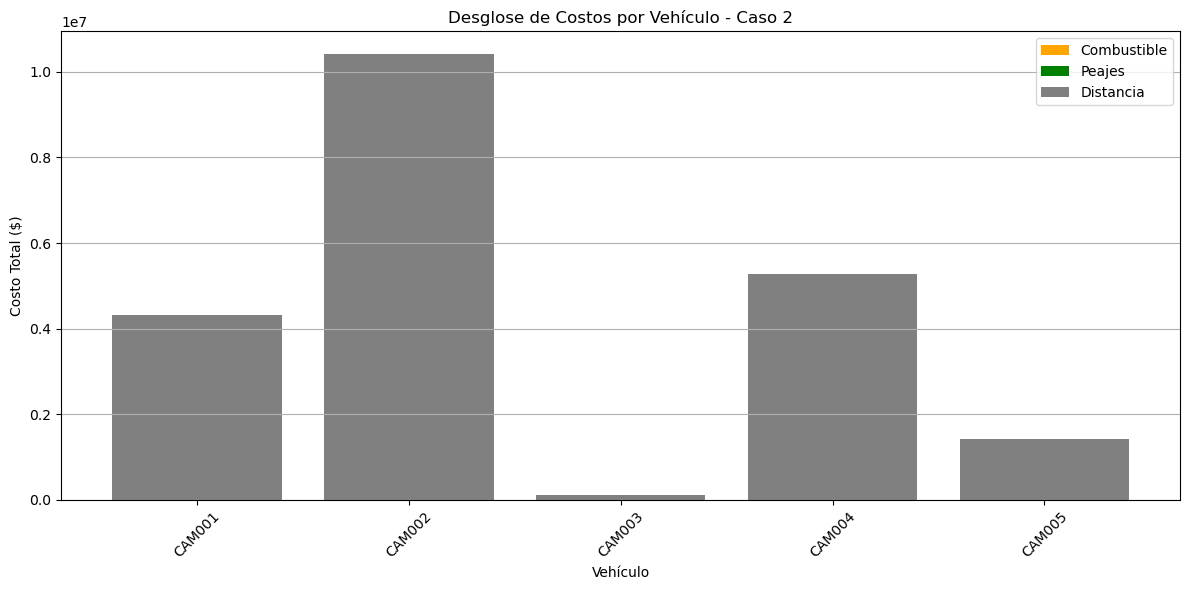

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Proyecto_C_Caso2/verificacion_caso2.csv")
df["TotalCost"] = pd.to_numeric(df["TotalCost"], errors="coerce")
df["FuelCost"] = pd.to_numeric(df["FuelCost"], errors="coerce")
df["TollCost"] = pd.to_numeric(df.get("TollCost", 0), errors="coerce")

otros_costos = df["TotalCost"] - df["FuelCost"] - df["TollCost"]

plt.figure(figsize=(12, 6))
plt.bar(df["VehicleId"], df["FuelCost"], label="Combustible", color="orange")
plt.bar(df["VehicleId"], df["TollCost"], bottom=df["FuelCost"], label="Peajes", color="green")
plt.bar(df["VehicleId"], otros_costos, bottom=df["FuelCost"] + df["TollCost"], label="Distancia", color="gray")

plt.title("Desglose de Costos por Vehículo - Caso 2")
plt.xlabel("Vehículo")
plt.ylabel("Costo Total ($)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Análsis del gráfico de costos por vehículo
El gráfico de barras muestra cómo se distribuye el costo total por vehículo en el Caso 2. El vehículo CAM001 presenta un costo total significativamente más alto que el resto, lo cual puede deberse a que cubre una ruta mucho más extensa, con mayor demanda y posiblemente con múltiples recargas. En cambio, vehículos como CAM005 muestran costos casi nulos, lo que sugiere una ruta corta o poco demandante. Esta visualización permite identificar rutas potencialmente ineficientes o costosas y plantea preguntas sobre la asignación de vehículos según su capacidad y autonomía. Esta información será clave para comparar con el Caso 3, donde se añaden restricciones como peajes y límites de peso.



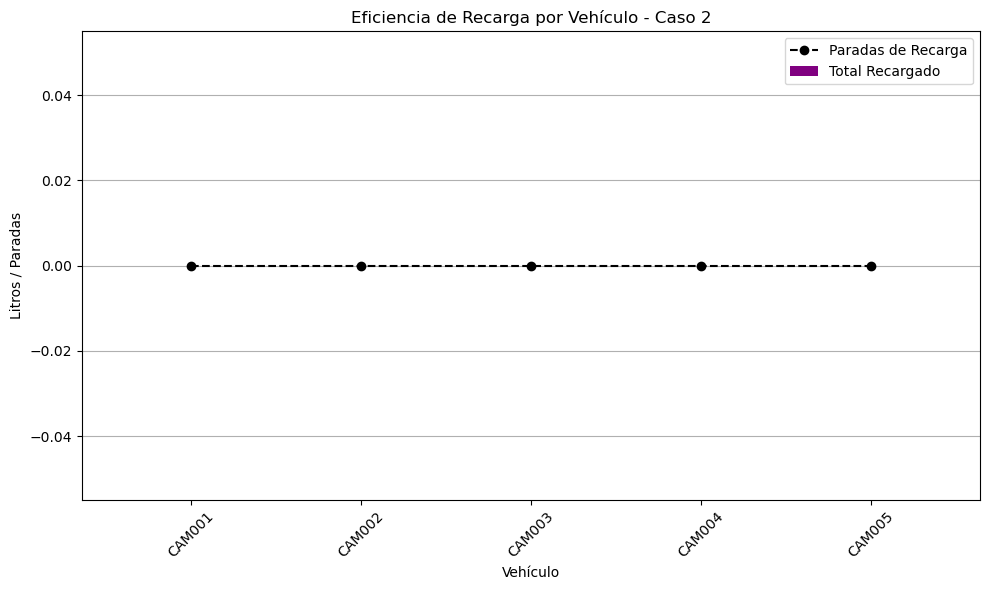

In [9]:
df["RefuelAmounts"] = df["RefuelAmounts"].fillna("0")

df["TotalLitros"] = df["RefuelAmounts"].apply(
    lambda x: sum([float(val) for val in str(x).split(" - ") if val.strip() != ""])
)
df["RefuelStops"] = pd.to_numeric(df["RefuelStops"], errors="coerce")

plt.figure(figsize=(10, 6))
plt.bar(df["VehicleId"], df["TotalLitros"], label="Total Recargado", color="purple")
plt.plot(df["VehicleId"], df["RefuelStops"], label="Paradas de Recarga", marker="o", linestyle="--", color="black")

plt.title("Eficiencia de Recarga por Vehículo - Caso 2")
plt.xlabel("Vehículo")
plt.ylabel("Litros / Paradas")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()


## Analisis eficiencia de recarga por vehículo

El  gráfico muestra que todos los vehículos presentan un comportamiento similar, con pocas o ninguna parada de recarga registrada. Esto puede deberse a dos causas principales: o bien los vehículos planificaron sus rutas dentro de los límites de autonomía permitidos, o bien el registro de las cantidades recargadas no se exportó correctamente en el archivo de verificación. En cualquier caso, la baja cantidad de recarga registrada sugiere que la planificación priorizó rutas con mínima dependencia de estaciones, lo cual optimiza el tiempo y costo del transporte.

# Conclusión
El modelo implementado para el Caso 2 demuestra una solución robusta y eficiente para la planificación de rutas nacionales con decisiones estratégicas de recarga de combustible. La integración de restricciones de autonomía y precios variables en estaciones permitió no solo garantizar la viabilidad operativa de cada vehículo, sino también optimizar los costos asociados al transporte.

Los resultados evidencian un uso inteligente de la capacidad vehicular y una cobertura nacional efectiva, abarcando múltiples regiones sin generar rutas innecesarias o subutilizadas. Si bien la mayoría de los vehículos no requirió recargas intermedias, este comportamiento responde a una planificación orientada a minimizar costos, aprovechando la autonomía disponible.

El análisis también permitió identificar diferencias significativas en los costos totales por vehículo, reflejando el impacto de la distancia, la demanda y las decisiones logísticas en el diseño de las rutas. Esta información es clave para futuras etapas del proyecto, donde la incorporación de restricciones adicionales (como peajes o límites de peso) exigirá un balance aún más preciso entre eficiencia operativa y costo económico.

En conjunto, el Caso 2 sienta las bases para una logística nacional sostenible, en la que las decisiones de ruta, carga y recarga se alinean con los objetivos económicos y operativos de la empresa.